In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_image(image, title, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

In [3]:
def detect_and_highlight_circles(image, kernel_size = 5, dp = 1, min_dist = 20,
                                 param1 = 100, param2 = 50, min_radius = 0, max_radius = 0):
    """
    Note: When `max_radius` is set to 0, the function will use max(image.shape) as the value.
    Source: https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
    """

    image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image
    gray = cv2.medianBlur(gray, kernel_size)

    circles = cv2.HoughCircles(
        gray,
        method=cv2.HOUGH_GRADIENT,
        dp=dp,
        minDist=min_dist,
        param1=param1,
        param2=param2,
        minRadius=min_radius,
        maxRadius=max_radius
    )
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(image, center, 2, (0, 255, 0), 3)
            cv2.circle(image, center, radius, (0, 0, 255), 3)

    return image, len(circles[0]) if circles is not None else 0

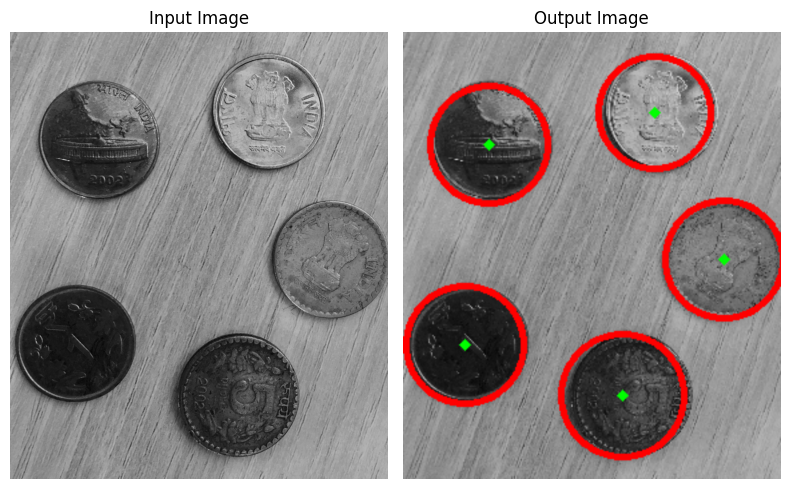

In [4]:
DATA_DIR = '../images/'
img_path = DATA_DIR + 'coin-detection.jpg'

input_image = cv2.imread(img_path)
original_shape = input_image.shape

resized_image = cv2.resize(input_image, (original_shape[1] // 8, original_shape[0] // 8))

output_image, _ = detect_and_highlight_circles(resized_image)
output_image = cv2.resize(output_image, (original_shape[1], original_shape[0]))

_, axs = plt.subplots(1, 2, figsize=(8, 5))

plot_image(input_image, title="Input Image", ax=axs[0])
plot_image(output_image, title="Output Image", ax=axs[1])
plt.tight_layout()
plt.show()


Detailed Parameter Analysis:
--------------------------------------------------


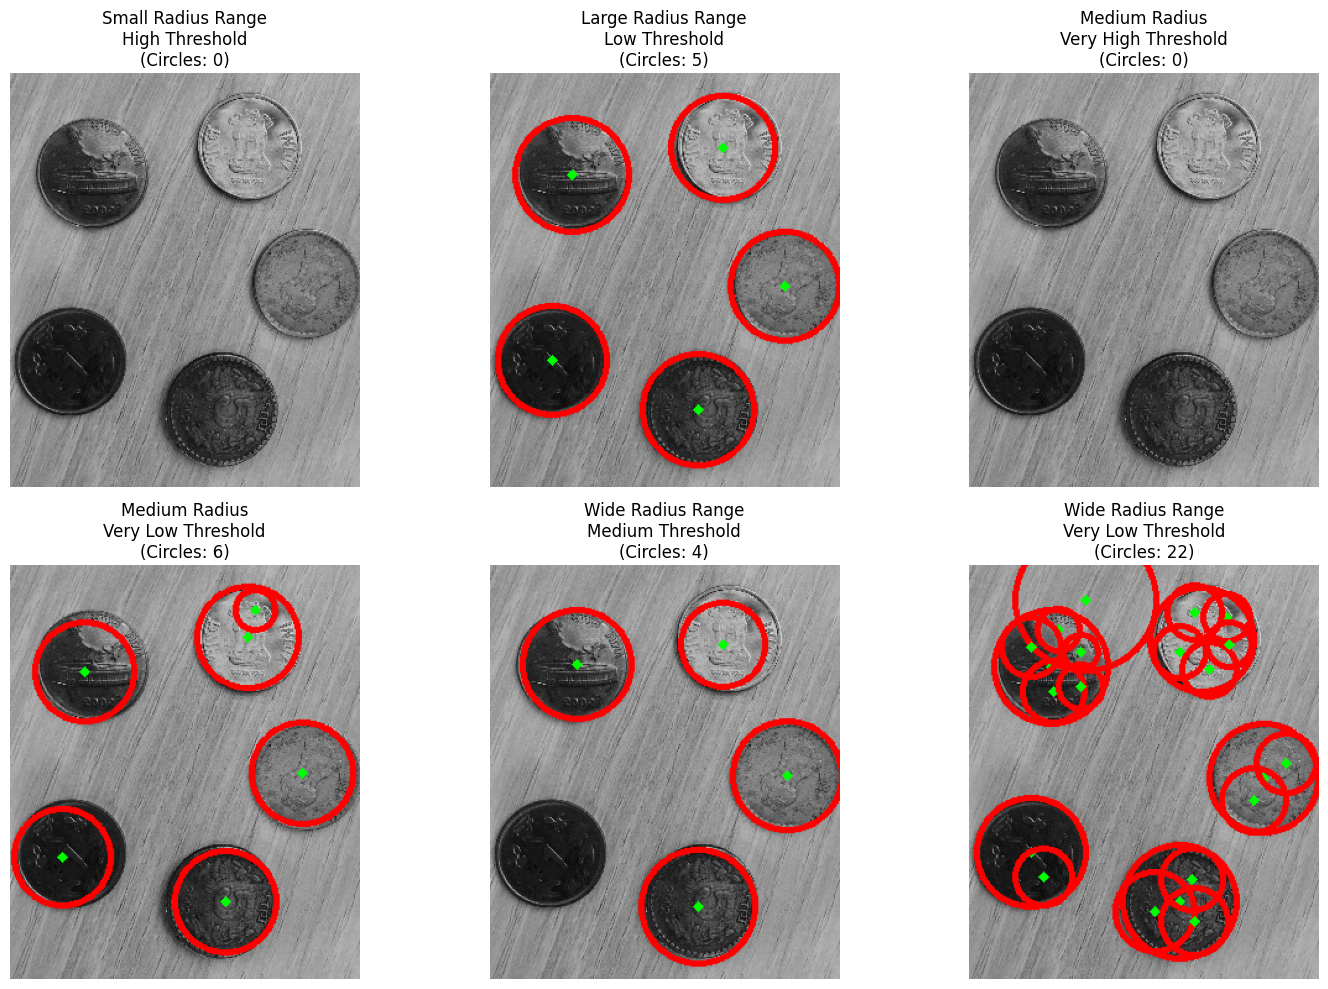

In [ ]:
def experiment_with_parameters(image):
    height, width = image.shape[:2]
    max_dimension = min(height, width)
    
    experiments = [
        {
            'title': 'Small Radius Range\nHigh Threshold',
            'params': {
                'min_radius': int(max_dimension * 0.03),  # 3% of image dimension
                'max_radius': int(max_dimension * 0.08),  # 8% of image dimension
                'param2': 70  # High accumulator threshold
            }
        },
        {
            'title': 'Large Radius Range\nLow Threshold',
            'params': {
                'min_radius': int(max_dimension * 0.1),   # 10% of image dimension
                'max_radius': int(max_dimension * 0.25),  # 25% of image dimension
                'param2': 30  # Low accumulator threshold
            }
        },
        {
            'title': 'Medium Radius\nVery High Threshold',
            'params': {
                'min_radius': int(max_dimension * 0.05),  # 5% of image dimension
                'max_radius': int(max_dimension * 0.15),  # 15% of image dimension
                'param2': 90  # Very high accumulator threshold
            }
        },
        {
            'title': 'Medium Radius\nVery Low Threshold',
            'params': {
                'min_radius': int(max_dimension * 0.05),  # 5% of image dimension
                'max_radius': int(max_dimension * 0.15),  # 15% of image dimension
                'param2': 20  # Very low accumulator threshold
            }
        },
        {
            'title': 'Wide Radius Range\nMedium Threshold',
            'params': {
                'min_radius': int(max_dimension * 0.03),  # 3% of image dimension
                'max_radius': int(max_dimension * 0.25),  # 25% of image dimension
                'param2': 50  # Medium accumulator threshold
            }
        },
        {
            'title': 'Wide Radius Range\nVery Low Threshold',
            'params': {
                'min_radius': int(max_dimension * 0.03),  # 3% of image dimension
                'max_radius': int(max_dimension * 0.25),  # 25% of image dimension
                'param2': 20  # Very low accumulator threshold
            }
        }
    ]

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()

    print("\nDetailed Parameter Analysis:")
    print("-" * 50)
    
    for idx, experiment in enumerate(experiments):
        result_image, num_circles = detect_and_highlight_circles(
            image,
            **experiment['params']
        )
        
        title = f"{experiment['title']}\n(Circles: {num_circles})"
        plot_image(result_image, title, axs[idx])

    plt.tight_layout()
    plt.show()

    return experiments

experiments = experiment_with_parameters(resized_image)

## General Remarks on Varying Radius Ranges and Accumulator Thresholds

### 1. Impact of Radius Range

- A **small radius range** (e.g., 3%-8% of the image dimensions) often fails to detect larger circles, as it limits the algorithm's search space to only small objects.
- A **wide radius range** (e.g., 3%-25%) increases the likelihood of detecting circles of varying sizes but also introduces false positives, especially when combined with low thresholds.

### 2. Impact of Accumulator Threshold (`param2`)

- A **high accumulator threshold** (e.g., `param2 = 70-90`) makes the algorithm strict, registering only strong and clear circle candidates. While this minimizes false positives, it can lead to missed detections (false negatives), particularly for coins with weak or partially visible edges.
- A **low accumulator threshold** (e.g., `param2 = 20-30`) increases sensitivity, detecting even faint edges. However, this often results in over-detection, with multiple false positives and overlapping circles.

### 3. Combination of Radius Range and Threshold

- Narrowing the radius range and lowering the threshold tends to improve circle detection for objects with consistent sizes and well-defined edges.
- Conversely, a wide radius range with a very low threshold leads to over-detection, as observed in the **Wide Radius Range, Very Low Threshold** result, where several overlapping and redundant circles were detected.

### 4. Best Performing Configurations

- **Large Radius Range, Low Threshold** (Circles: 5): This configuration successfully detected most coins without introducing significant false positives, demonstrating a good balance of sensitivity and specificity.
- **Medium Radius, Very Low Threshold** (Circles: 6): This configuration detected all coins, but the very low threshold increases the risk of false positives in noisier images.

### 5. Worst Performing Configurations

- **Small Radius Range, High Threshold** (Circles: 0): Completely failed to detect any circles due to a combination of a restrictive radius range and strict thresholding.
- **Wide Radius Range, Very Low Threshold** (Circles: 22): Drastically over-detected circles, emphasizing the risk of setting thresholds too low in combination with a wide radius range.